# import modules

In [1]:
%matplotlib qt
# %matplotlib notebook
#%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import griddata
from scipy.constants import elementary_charge
import matplotlib.tri as tri
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

import shutil

# scientific format of axis labels
def sci_format():                                                               
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)                          
    fmt.set_powerlimits((-2, 3))                                                
    return (fmt) 

# class definition

In [2]:
class CosyrAnalyze(object):
    
    def __init__(self, gamma, data_dir="../..", # path to data
                 pid=0, # particle index
                 traj_type = 2, # 1: straightline, 2: synchrotron, 3: undulator
                 load_data_all=0, # if to load all data
                 wf_xy_rotate = 0, # rotate wavefront positions and co-moving mesh from x-y to x'-y'
                 wf_xy2polar =0, # convert wavefront positions from x-y to polar coordinates
                ):
        self = locals().pop("self")
        for name, val in locals().items():
            print("setting " + name + " to ", val)
            setattr(self, name, val)
        
        if self.load_data_all:
            self.load_trajectory()
            self.load_wavefronts()
            self.load_cmesh()
            self.load_cmesh_polar()
            print("done reading.")
        
        if self.wf_xy_rotate:
            from scipy.spatial.transform import Rotation as R
            if not self.load_data_all:
                self.load_trajectory()
                self.load_wavefronts()
                self.load_cmesh()                
            r0 = np.sqrt(self.curr_x**2+self.curr_y**2)
            alpha0 = np.arctan2(self.curr_x, self.curr_y)
            print("alpha0 = ", alpha0)
            r = R.from_euler('z', alpha0)
            rot_matrix = r.as_matrix()
            print("rot_matrix=", rot_matrix)
            print("curr_prime = ", r.apply(np.asarray([self.curr_x, self.curr_y, 0.0])))
            self.wf_xprime = self.wf_x * rot_matrix[0,0] + self.wf_y * rot_matrix[0,1]
            self.wf_yprime = self.wf_x * rot_matrix[1,0] + self.wf_y * rot_matrix[1,1]
            self.cmesh_xprime = self.cmesh_x * rot_matrix[0,0] + self.cmesh_y * rot_matrix[0,1]
            self.cmesh_yprime = self.cmesh_x * rot_matrix[1,0] + self.cmesh_y * rot_matrix[1,1]            
            # axis range
            self.xprime_lim_cmesh = [self.cmesh_xprime.min(), self.cmesh_xprime.max()] 
            self.yprime_lim_cmesh = [self.cmesh_yprime.min(), self.cmesh_yprime.max()] 
            
        if self.wf_xy2polar:
            if not self.load_data_all:
                self.load_trajectory()
                self.load_wavefronts()
            r0 = np.sqrt(self.curr_x**2+self.curr_y**2)
            alpha0 = np.arctan2(self.curr_y, self.curr_x)
            self.wf_alpha = np.zeros(self.wf_x.shape[0])
            self.wf_chi = np.zeros(self.wf_x.shape[0])
            for i in range(self.wf_x.shape[0]):
                r = np.sqrt(self.wf_x[i]**2+self.wf_y[i]**2)
                alpha = np.arctan2(self.wf_y[i], self.wf_x[i])
                self.wf_alpha[i] = alpha0 - alpha
                self.wf_chi[i] = r - r0

    def load_trajectory(self):
        # electron trajectory
        self.traj_x, self.traj_y = np.loadtxt(
            self.data_dir+'/data/trajectory_{}_0.csv'.format(self.pid), delimiter=',', unpack=True)
        # Current electron position
        self.curr_x = 0.5*(self.traj_x[-1] + self.traj_x[-2]) 
        self.curr_y = 0.5*(self.traj_y[-1] + self.traj_y[-2])
        # predefined trajectory according to trajectory type
        self.rotation_angle = 0.0
        if self.traj_type==2:
            self.traj_x_predef = np.linspace(0,1,1000)
            self.traj_y_predef = np.sqrt(1-self.traj_x_predef**2)
        
    def load_wavefronts(self):
        # positions
        self.wf_x, self.wf_y = np.loadtxt(
            self.data_dir+'/data/wavefronts_{}_0.csv'.format(self.pid), delimiter=',', unpack=True)
        # axis range
        self.xlim_wf = [self.wf_x.min(), self.wf_x.max()] 
        self.ylim_wf = [self.wf_y.min(), self.wf_y.max()]
        # fields 
        self.wf_vfld, self.wf_afld, self.wf_tfld = np.loadtxt(
            self.data_dir+'/data/field_{}_0.csv'.format(self.pid), delimiter=',', unpack=True)
        self.wf_vfld /= self.gamma**4.0
        self.wf_afld /= self.gamma**4.0
        self.wf_tfld /= self.gamma**4.0
        
    def load_cmesh(self):
        from scipy.spatial.transform import Rotation as R
        # positions
        self.cmesh_x, self.cmesh_y = np.loadtxt(
            self.data_dir+'/data/comoving_mesh_pos.csv', delimiter=',', unpack=True)
        # axis range
        self.xlim_cmesh = [self.cmesh_x.min(), self.cmesh_x.max()] 
        self.ylim_cmesh = [self.cmesh_y.min(), self.cmesh_y.max()]
        # fields
        self.cmesh_vfld, self.cmesh_afld, self.cmesh_tfld = np.loadtxt(
            self.data_dir+'/data/comoving_mesh_field.csv', delimiter=',', unpack=True)
        #self.cmesh_vfld /= self.gamma**4.0
        #self.cmesh_afld /= self.gamma**4.0
        #self.cmesh_tfld /= self.gamma**4.0

    def load_error(self):
        self.error = np.loadtxt(self.data_dir+'/data/error_map.csv', delimiter=',', unpack=True)
        self.exact_field = np.loadtxt(self.data_dir+'/data/exact_values.csv', delimiter=',', unpack=True)
        
    def load_cmesh_polar(self):
        # positions, fields
#         self.cmesh_polar_ang, self.cmesh_polar_rad, self.cmesh_polar_vfld, \
#             self.cmesh_polar_afld, self.cmesh_polar_tfld = np.loadtxt(
#                             self.data_dir+'/data/comoving_mesh_rad_ang.data', delimiter=',', unpack=True)
        self.cmesh_polar_ang, self.cmesh_polar_rad, self.cmesh_polar_afld, =\
            np.loadtxt(self.data_dir+'/data/comoving_mesh_rad_ang.csv', delimiter=',', unpack=True)
        self.cmesh_polar_rad -= 1.0 # change r to chi=r-1
        # axis range
        self.xlim_cmesh_ang = [self.cmesh_polar_ang.min(), self.cmesh_polar_ang.max()] 
        self.ylim_cmesh_rad = [self.cmesh_polar_rad.min(), self.cmesh_polar_rad.max()]

# Plotting

## wavefronts, co-mesh & fields

In [3]:
gamma = 1000
ndirs = 200

In [4]:
a=CosyrAnalyze(gamma, "../build", pid=0, load_data_all=1, wf_xy_rotate=0, )

setting gamma to  1000
setting data_dir to  ../build
setting pid to  0
setting traj_type to  2
setting load_data_all to  1
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting self to  <__main__.CosyrAnalyze object at 0x12aa84080>
done reading.


In [5]:
def load_wavelets(path,filename,assign_field_value=True) :
    import numpy as np
    data = np.genfromtxt(path+"/"+filename, delimiter=",") # read CSV file
    #data = dat[:1000,:]
    nwavelets = data.shape[0]
    field = np.zeros(nwavelets)

    def get_field(pos):
        x = pos[:,0]
        y = pos[:,1]
        ymax = y.max()
        ymin = y.min()
        x_fact = -0.0000001
        y_fact = -0.0005
        return np.exp((x_fact*x*x) + (y_fact*y*y))
        #return np.cos(5.0*y*2*np.pi/(ymax-ymin))   # test case, assign test field of cos(x)

    if (assign_field_value) : 
        field = get_field(data[:,:2])

    # ensure we pass different array addresses for wavelet x,y coordinate 
    wx = data[:,0].copy()
    wy = data[:,1].copy()
    return wx, wy, field

In [6]:
wavelet_path = "/Users/hoby/dev/csr/cosyr/input"
wavelet_filename = "wavelets_adaptative.csv"
wavelet_x, wavelet_y, wavelet_field = load_wavelets(wavelet_path, wavelet_filename)
# unscale if necessary
wavelet_x /= gamma**3.0
wavelet_y /= gamma**2.0
wavelet_type = 1
if (wavelet_type == 0) :
    # convert to global (x,y) coordinate
    wavelet_x_prime = wavelet_x.copy()
    wavelet_y_prime = wavelet_y + 1.0
    rotation_angle = 0.19989890421779444  # positive for counter clock-wise rotation
    wavelet_x = wavelet_x_prime*np.cos(rotation_angle) + wavelet_y_prime*np.sin(rotation_angle)
    wavelet_y = -wavelet_x_prime*np.sin(rotation_angle) + wavelet_y_prime*np.cos(rotation_angle) 

print("wavelet_x: (min,max) = ", wavelet_x.min(), wavelet_x.max())
print("wavelet_y: (min,max) = ", wavelet_y.min(), wavelet_y.max())


wavelet_x: (min,max) =  -5.036766987143398e-06 1.0513008183041598e-05
wavelet_y: (min,max) =  -5.000000000005039e-05 5.000000000016063e-05


In [7]:
#%matplotlib inline
# plot
fig, axes = plt.subplots(1,1, figsize=[9,7])
ax=axes
ax.set_title("wavefronts & comove-mesh")
#ax.plot(a.traj_x_predef, a.traj_y_predef, 'k', linewidth=0.5, label='predefined traj.')
#ax.plot(a.traj_x, a.traj_y, 'r', linewidth=0.5, label='actual traj.')
#ax.plot(a.curr_x, a.curr_y, 'r.', markersize=20, label="current pos.")
ax.scatter(a.wf_x, a.wf_y, s=.1, facecolor='C0', label="wavefronts")
#ax.scatter(wavelet_x, wavelet_y, s=.1, facecolor='C0', label="prescribed wavefronts")
ax.scatter(a.cmesh_x, a.cmesh_y, s=.1, facecolor='C1', label="comove-mesh")
ax.set_xlim(a.xlim_cmesh)
ax.set_ylim(a.ylim_cmesh)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.legend(loc="upper right")

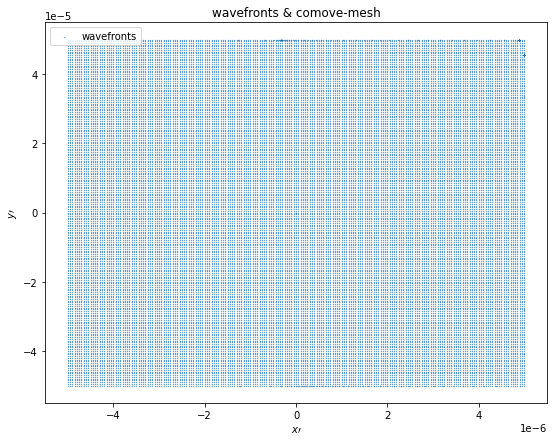

In [8]:
# plot
#%matplotlib qt
#fig = plt.figure()
%matplotlib inline
fig, axes = plt.subplots(1,1, figsize=[9,7])
ax=axes
ax.set_title("wavefronts & comove-mesh")
#ax.plot(a.traj_x_predef, a.traj_y_predef, 'k', linewidth=0.5, label='predefined traj.')
#ax.plot(a.traj_x, a.traj_y, 'r', linewidth=0.5, label='actual traj.')
#ax.plot(a.curr_x, a.curr_y, 'r.', markersize=20, label="current pos.")
ax.scatter(a.wf_x, a.wf_y, s=.1, facecolor='C0', label="wavefronts")
#ax.scatter(a.wf_x[:ndirs], a.wf_y[:ndirs], s=10, facecolor='b', label="first wavefronts")
#ax.scatter(a.wf_xprime[:], a.wf_yprime[:], s=.3, facecolor='C0', label="wavefronts")
#ax.scatter(a.wf_xprime[-400*ndirs:], a.wf_yprime[-400*ndirs:], s=.3, facecolor='C0', label="wavefronts")
#ax.scatter(a.cmesh_x, a.cmesh_y, s=.1, facecolor='C1', label="comove-mesh")
#ax.scatter(a.cmesh_xprime, a.cmesh_yprime, s=.1, facecolor='C1', label="comove-mesh")
#ax.set_xlim(np.multiply(a.xprime_lim_cmesh,100))
#ax.set_ylim(a.yprime_lim_cmesh)
ax.set_xlabel(r'$x\prime$')
ax.set_ylabel(r'$y\prime$')
plt.legend(loc="best")

In [9]:
print(a.cmesh_x.min(), a.cmesh_y.min())
print(a.cmesh_x.max(), a.cmesh_y.max())

-5.00024999992e-06 -5.00000125157e-05
5.00025000004e-06 4.99999999919e-05


Text(0, 0.5, '$y\\prime$')

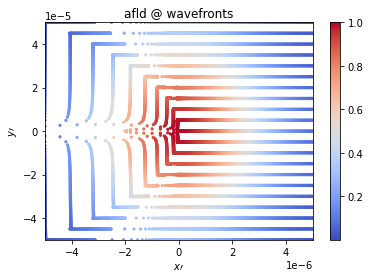

In [10]:
%matplotlib inline
wavelet_path = "/Users/hoby/dev/csr/cosyr/input"
wavelet_filename = "wavelets_adaptative.csv"
wavelet_x, wavelet_y, wavelet_field = load_wavelets(wavelet_path, wavelet_filename)
wavelet_x /= gamma**3.0
wavelet_y /= gamma**2.0

fig, axes = plt.subplots(1,1, figsize=[6,4])
ax=axes
ax.set_title("afld @ wavefronts")
#sc=ax.scatter(a.wf_x, a.wf_y, c=a.wf_tfld, marker='o', s=5, cmap="coolwarm")
sc=ax.scatter(wavelet_x, wavelet_y, c=wavelet_field, marker='o', s=5, cmap="coolwarm")
#ax.plot(a.curr_x, a.curr_y, 'c.', markersize=5)
#ax.set_xlim(np.multiply(a.xprime_lim_cmesh,1))
#ax.set_ylim((a.yprime_lim_cmesh[0]-1)*1+1, (a.yprime_lim_cmesh[1]-1)*1+1)
ax.set_xlim(a.xlim_cmesh)
ax.set_ylim(a.ylim_cmesh)
fig.colorbar(sc, ax=ax)
#sc.set_clim(-1, 1)
ax.set_xlabel(r'$x\prime$')
ax.set_ylabel(r'$y\prime$')

In [11]:
a=CosyrAnalyze(gamma, "../build", pid=0, load_data_all=1, wf_xy_rotate=1)
x1, y1 = np.meshgrid(np.linspace(a.xprime_lim_cmesh[0]*10, a.xprime_lim_cmesh[1]*10, 10), np.linspace(a.yprime_lim_cmesh[0], a.yprime_lim_cmesh[1],10))
print(x1)
print(y1)
mesh_tfld = griddata((a.wf_xprime, a.wf_yprime), a.wf_tfld, (x1, y1), method='linear')

setting gamma to  1000
setting data_dir to  ../build
setting pid to  0
setting traj_type to  2
setting load_data_all to  1
setting wf_xy_rotate to  1
setting wf_xy2polar to  0
setting self to  <__main__.CosyrAnalyze object at 0x12d3aac50>
done reading.
alpha0 =  0.19899990873666304
rot_matrix= [[ 0.98026478 -0.19768908  0.        ]
 [ 0.19768908  0.98026478  0.        ]
 [ 0.          0.          1.        ]]
curr_prime =  [-2.77555756e-17  9.99999751e-01  0.00000000e+00]
[[-1.47860202e-04 -1.15002919e-04 -8.21456351e-05 -4.92883515e-05
  -1.64310678e-05  1.64262159e-05  4.92834996e-05  8.21407833e-05
   1.14998067e-04  1.47855351e-04]
 [-1.47860202e-04 -1.15002919e-04 -8.21456351e-05 -4.92883515e-05
  -1.64310678e-05  1.64262159e-05  4.92834996e-05  8.21407833e-05
   1.14998067e-04  1.47855351e-04]
 [-1.47860202e-04 -1.15002919e-04 -8.21456351e-05 -4.92883515e-05
  -1.64310678e-05  1.64262159e-05  4.92834996e-05  8.21407833e-05
   1.14998067e-04  1.47855351e-04]
 [-1.47860202e-04 -1.1

/Users/hoby/dev/csr/cosyr/venv/lib/python3.7/site-packages/matplotlib/image.py:455: RuntimeWarning: overflow encountered in double_scalars
  newmin = vmid - dv * fact
/Users/hoby/dev/csr/cosyr/venv/lib/python3.7/site-packages/matplotlib/image.py:460: RuntimeWarning: overflow encountered in double_scalars
  newmax = vmid + dv * fact


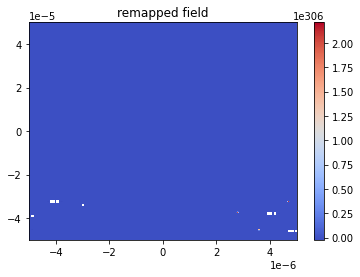

In [15]:
#%matplotlib qt
%matplotlib inline
plt.figure()
plt.title("remapped field")
plt.imshow(a.cmesh_tfld.reshape([201,201]).T,aspect="auto",cmap="coolwarm", origin="upper", extent=[a.xlim_cmesh[0], a.xlim_cmesh[1], a.ylim_cmesh[0], a.ylim_cmesh[1]])
#plt.clim(-1,1)
plt.colorbar()

ValueError: cannot reshape array of size 40401 into shape (101,101)

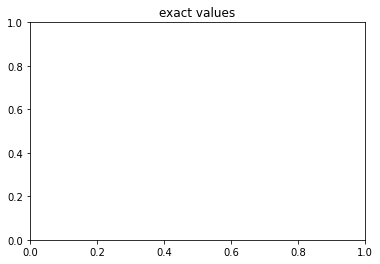

In [16]:
%matplotlib inline
a.load_error()
plt.title("exact values")
plt.imshow(a.exact_field.reshape([201,201]).T,aspect="auto",cmap="coolwarm")
#plt.clim(-1,1)
plt.colorbar()

a.wf_tfld.min(), a.wf_tfld.max()

ValueError: cannot reshape array of size 40401 into shape (101,101)

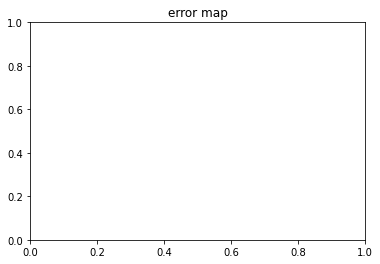

In [14]:
%matplotlib inline
plt.title("error map")
plt.imshow(a.error.reshape([201,201]).T,aspect="auto",cmap="coolwarm")
#plt.clim(0,0.5)
plt.colorbar()

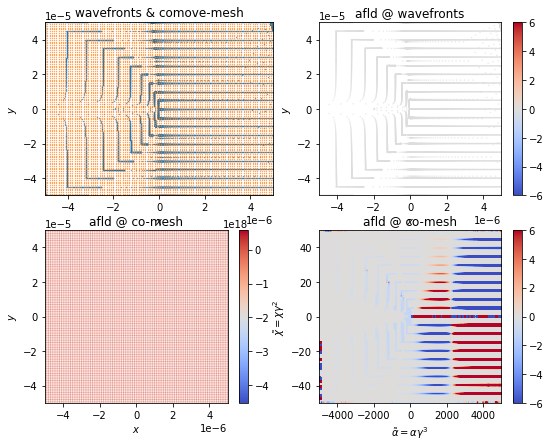

In [15]:
%matplotlib inline
# read data
# a=CosyrAnalyze("../..", pid=0, load_data_all=1,)

#gamma = 1000
#a=CosyrAnalyze("../", pid=0, load_data_all=1,)


# plot
fig, axes = plt.subplots(2,2, figsize=[9,7])
ax=axes[0,0]
ax.set_title("wavefronts & comove-mesh")
ax.plot(a.traj_x_predef, a.traj_y_predef, 'k', linewidth=0.5, label='predefined traj.')
ax.plot(a.curr_x, a.curr_y, 'c.', markersize=5)
ax.scatter(a.wf_x, a.wf_y, s=.1, facecolor='C0', label="wavefronts")
ax.scatter(a.cmesh_x, a.cmesh_y, s=.1, facecolor='C1', label="comove-mesh")
ax.set_xlim(a.xlim_cmesh)
ax.set_ylim(a.ylim_cmesh)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax=axes[0,1]
ax.set_title("afld @ wavefronts")
sc=ax.scatter(a.wf_x, a.wf_y, c=-a.wf_afld/1e4, marker='o', s=.1, cmap="coolwarm")
ax.plot(a.curr_x, a.curr_y, 'c.', markersize=5)
ax.set_xlim(a.xlim_cmesh)
ax.set_ylim(a.ylim_cmesh)
fig.colorbar(sc, ax=ax)
sc.set_clim(-6, 6)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax=axes[1,0]
ax.set_title("afld @ co-mesh")
sc=ax.scatter(a.cmesh_x, a.cmesh_y, c=-a.cmesh_tfld, marker='o', s=.1, cmap="coolwarm")
ax.plot(a.curr_x, a.curr_y, 'c.', markersize=5)
ax.set_xlim(a.xlim_cmesh)
ax.set_ylim(a.ylim_cmesh)
fig.colorbar(sc, ax=ax)
#sc.set_clim(-6, 6)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax=axes[1,1]
ax.set_title("afld @ co-mesh")
dim=201
cmesh_polar_afld_reshaped = a.cmesh_polar_afld.reshape(dim,dim).T
cmesh_polar_ang_reshaped = a.cmesh_polar_ang.reshape(dim,dim).T
cmesh_polar_rad_reshaped = a.cmesh_polar_rad.reshape(dim,dim).T
# rescale
cmesh_polar_ang_reshaped *=gamma**3.0
cmesh_polar_rad_reshaped *=gamma**2.0
img=ax.imshow(-cmesh_polar_afld_reshaped/gamma**4, aspect="auto", origin="lower", cmap="coolwarm",
                extent=[cmesh_polar_ang_reshaped[0,0], cmesh_polar_ang_reshaped[0,-1],
                         cmesh_polar_rad_reshaped[-1,0], cmesh_polar_rad_reshaped[0,0]])
cb=fig.colorbar(img, ax=ax)
img.set_clim(-6, 6)
# clevels=np.arange(-6,8,2)
# p1=ax.contour(cmesh_polar_ang_reshaped, cmesh_polar_rad_reshaped, -cmesh_polar_afld_reshaped/gamma**4,
#               levels=clevels, cmap='jet')
# p1.set_clim(-6, 6)
# ax.clabel(p1, inline=1, colors="k", fmt="%1.0f", fontsize=7)
# cb=plt.colorbar(p1, orientation="horizontal")
ax.set_xlabel(r'$\tilde{\alpha}=\alpha\gamma^3$')
ax.set_ylabel(r'$\tilde{\chi}=\chi\gamma^2$')

# cbax=ax1.inset_axes([0.1,1.15,0.8,0.04])
# p1=ax1.imshow(coeff_x, origin="lower", aspect="auto", cmap=cmap,
#           extent=[gamma[0], gamma[-1], theta[0], theta[-1]], )
# ax1.clabel(p2, inline=1, colors="k", fmt="%1.1f", fontsize=7)
# cb=plt.colorbar(p1, cax=cbax, orientation="horizontal")

#plt.tight_layout()
plt.show()

# Benchmark

## realistic beam-size

### some estimate

In [4]:
gamma = 1000
r_beam = 50 # um, beam radius in radial direction
l_beam = 3000 # um, beam length in angular direction
num_part = 1e10 # number of particles 
Q_beam = num_part * elementary_charge / 1e-9 # nC
print ("beam charge: {} nC".format(Q_beam))

V_beam = math.pi*r_beam**2.0 * l_beam
V_part = V_beam/num_part # um^3, volume of single particle
inter_part = V_part**(1/3.) * 1e3 # nm
print ("inter-particle distance: {} nm".format(inter_part))

delta_alpha = l_beam * 1e-6
delta_alpha_tilde = delta_alpha * gamma**3.0
delta_chi = 2 * r_beam * 1e-6 
delta_chi_tilde = delta_chi * gamma**2.0 
print ("delta_alpha={}, delta_alpha_tilde={}".format(delta_alpha, delta_alpha_tilde))
print ("delta_chi={}, delta_chi_tilde={}".format(delta_chi, delta_chi_tilde))

beam charge: 1.6021766339999997 nC
inter-particle distance: 133.06700394914688 nm
delta_alpha=0.003, delta_alpha_tilde=3000000.0
delta_chi=9.999999999999999e-05, delta_chi_tilde=99.99999999999999


### interpolated acceleration fields in (chi, alpha)

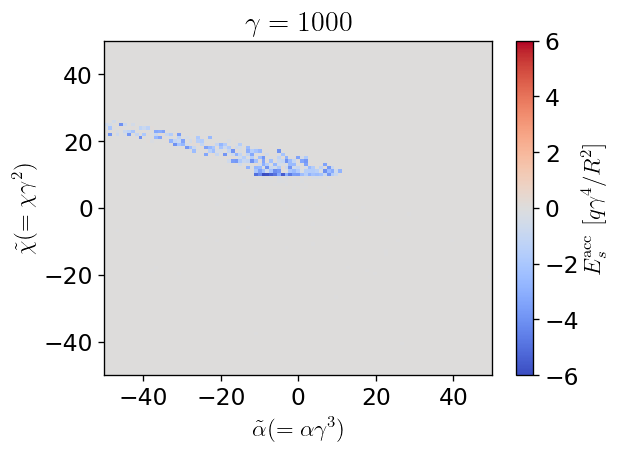

In [8]:
fig, axes = plt.subplots(1,1, figsize=[5.4,4], dpi=120)

gamma=1000

home_path = "/Users/hoby/dev/csr/cosyr"
#data_path = home_path+"/build".format(gamma)
data_path = home_path+"/build"
# data_path = home_path
num_gridpt_hor = num_gridpt_ver = 101


a=CosyrAnalyze(data_path, pid=0, load_data_all=0)
a.load_cmesh_polar()

# reshape as 2D arrays and normalization
cmesh_polar_afld = a.cmesh_polar_afld.reshape(num_gridpt_hor, num_gridpt_ver).T / -(gamma**4.0)
cmesh_polar_ang = a.cmesh_polar_ang.reshape(num_gridpt_hor, num_gridpt_ver).T * gamma**3.0
cmesh_polar_rad = a.cmesh_polar_rad.reshape(num_gridpt_hor, num_gridpt_ver).T * gamma**2.0

extent = [cmesh_polar_ang[0,0], cmesh_polar_ang[0,-1],
        cmesh_polar_rad[-1,0], cmesh_polar_rad[0,0]]

ax = axes
ax.set_title("$\gamma={}$".format(gamma), usetex=True)
img = ax.imshow(cmesh_polar_afld, aspect="auto", #origin="lower", 
              cmap="coolwarm", extent=extent)
img.set_clim(-6, 6)
cb = plt.colorbar(img, ax=ax)
cb.set_label(r"$E_s^{\rm acc}\ [q\gamma^4/R^2]$", usetex=True)
ax.set_xlabel(r'$\tilde{\alpha}(=\alpha\gamma^3)$', usetex=True)
ax.set_ylabel(r'$\tilde{\chi}(=\chi\gamma^2)$', usetex=True)
# add contour lines
# clevels=np.arange(-6,8,2)
# p1=ax.contour(cmesh_polar_ang, cmesh_polar_rad, cmesh_polar_afld,
#               levels=clevels, cmap='jet')
# # p1.set_clim(-6, 6)
# ax.clabel(p1, inline=1, colors="k", fmt="%1.0f", fontsize=12)
# # cb=plt.colorbar(p1, orientation="vertical")


plt.tight_layout()
plt.show()

### wavelets in (chi, alpha)

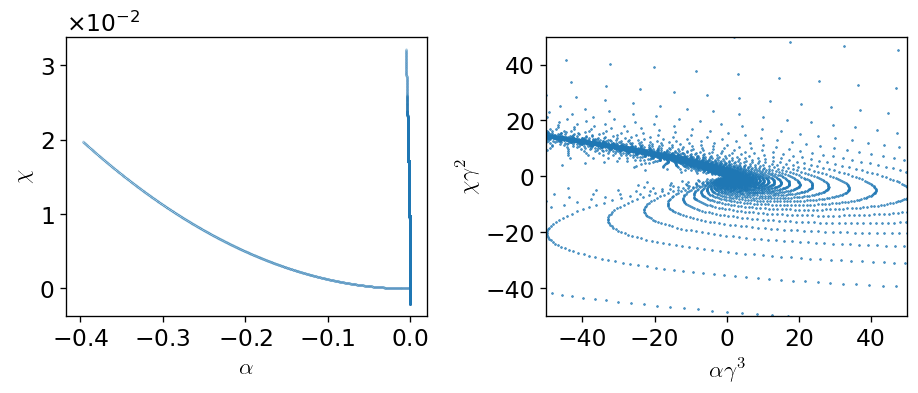

In [6]:
gamma=1000
home_path = "/Users/hoby/dev/csr/cosyr"
#data_path = home_path+"/run_real_beam_size".format(gamma)
data_path = home_path+"/build"
a=CosyrAnalyze(data_path, pid=0, load_data_all=0, wf_xy2polar=1)

def sci_format():
    fmt = mpl.ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-2, 3))
    return (fmt)

# usage


fig, axes = plt.subplots(1,2, figsize=[8,3.5], dpi=120)

ax = axes[0]
# ax.plot(a.wf_alpha*gamma**3, a.wf_chi*gamma**2, ".", markersize=.1)
ax.plot(a.wf_alpha, a.wf_chi, ".", markersize=.1)
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(-0.5, 0.5)
ax.set_xlabel(r"$\alpha$", usetex=True)
ax.set_ylabel(r"$\chi$", usetex=True)
ax.xaxis.set_major_formatter(sci_format())
ax.yaxis.set_major_formatter(sci_format())

ax = axes[1]
ax.plot(a.wf_alpha*gamma**3, a.wf_chi*gamma**2, ".", markersize=1)
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)
# ax.set_xlim(-.5, .5)
# ax.set_ylim(-.5, .5)
ax.set_xlabel(r"$\alpha\gamma^3$", usetex=True)
ax.set_ylabel(r"$\chi\gamma^2$", usetex=True)

# ax = axes[1]
# ax.plot(a.wf_x, a.wf_y, ".", markersize=0.1)
# # ax.plot(a.curr_x, a.curr_y, 'c.', markersize=5)
# ax.set_xlim(a.xlim_cmesh)
# ax.set_ylim(a.ylim_cmesh)



plt.tight_layout()